In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[[ 0.8]]
running params a3.080_b3.500_c0.110
Solved in 9.915581e-01 seconds (5.122871e-01 transient + 4.792709e-01 printed)


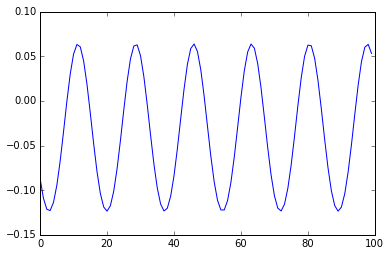

In [3]:
Nosc=1

length=1000 #2e5
translength=1000 #3000
stepsize=0.5

sigma=0.1

ymin=-4.0
ymax=4.0
xmin=-0.75
xmax=0.75

######################

from scipy import sparse
from scipy.integrate import odeint
import os, time

detune=0.001
alpha0=3.08
alpha1=1e-3*random.random(Nosc)+alpha0
alpha1=1.0/(alpha1)

length1=length*stepsize+1
tlength=translength*stepsize+1


S1=zeros((Nosc,Nosc))
for i in range(0,Nosc-1):
    S1[i,i+1]=0.2
S1[Nosc-1,0]=0.8

print S1

S=sparse.csr_matrix(S1)

#ic1=[]
#for line in file('fc0.txt'):
#	ic1.append(double(line))

def osc2(v, t, alpha1, beta1, coupling, S):
    x=v[0:len(v)/3]
    y=v[len(v)/3:2*len(v)/3]
    z=v[2*len(v)/3:len(v)]

    xdot = 3.9*(beta1*(y-x)\
        + 1.87e-6*( exp(3.9*(y-x)) - exp(-3.9*(y-x)) )\
        - 0.0072 + alpha1*(x-coupling*(S*x)) )
        #+ alpha1*(x-coupling*(S*x)) ) #NO IMPERFECTION!

    ydot = - z\
        - beta1*(y-x)\
        - 1.87e-6*( exp(3.9*(y-x)) - exp(-3.9*(y-x)) )

    zdot = y - 0.042*z
    
    vdot=[]
    vdot[0:len(v)/3] = xdot
    vdot[len(v)/3:2*len(v)/3] = ydot
    vdot[2*len(v)/3:len(v)] = zdot
    
    return vdot

for coupling in [0.11]:#arange(0.11,0.115,0.001): #[0.09]:
	try: os.mkdir('Data')
	except: pass

	#arange(3.535,3.55,0.001):
	for beta in [3.5]:
		beta1=1e-3*random.random(Nosc)+beta
		beta1=1.0/(beta1)
		outname='a%2.3f_b%2.3f_c%2.3f'%(alpha0,beta,coupling)
		print 'running params %s'%outname
		#set initial conditions
		#x=ic1		
		

		x=[]
		for n in range(0, Nosc):
			x.append(0.01*rand()+(-1)**(n+1)*3)
		for n in range(0, Nosc):	
			x.append((-1)**(n+1)*0.3)
		for n in range(0, Nosc):	
			x.append((-1)**(n+1)*1.0) 
		x=array(x)
		   
		time0=time.time()

		##transient
		timepoints = arange(1., tlength, stepsize)
		transient = odeint(osc2, x, timepoints, args=(alpha1, beta1, coupling, S))
		tran3=reshape(transient,(translength,Nosc*3))
		savetxt('data_transient.txt',tran3)

		x=transient[-1,:]
		time1=time.time()

		timepoints = arange(1., length1, stepsize)
		trajectory = odeint(osc2, x, timepoints, args=(alpha1, beta1, coupling, S))
		time2=time.time()
		x=trajectory[-1,:]
		print "Solved in %e seconds (%e transient + %e printed)" % (time2-time0,time1-time0,time2-time1)  
		
		plot(trajectory[:,0])
		savefig('traj.png')
		
		savetxt('fc.txt',trajectory[-1,:])		

		traj3=reshape(trajectory,(length,Nosc*3))	
		savetxt('data_trajectory.txt',traj3)

#time=arange()
v3=traj3[:,1]
        
clf()
plot(traj3[0:100,1],'-')
show()
#end

0.524574041367


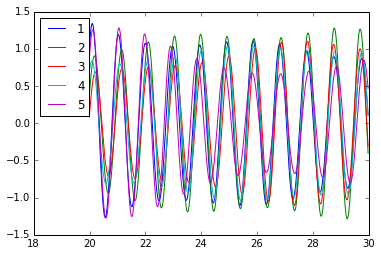

In [47]:
from scipy.integrate import odeint
from time import time

def eom(x,f): 
    u,v=x
    du=v
    dv= -(f**2) * u
    return du,dv

def coup(X,t,eq0,f0,ck,N):
    dx=[]
    dof=2 #degrees of freedom per oscillator
    for i in range(N):
        fi=f0[i]+(2*X[dof*i]
                  -X[mod(dof*(i+mod(dof*i+1,dof)),dof*N)]
                  -X[mod(dof*(i-mod(dof*i+1,dof)),dof*N)]
                  )*ck*X[dof*i]
        dx[dof*i:dof*(i+1)]=eq0(X[dof*i:dof*(i+1)],fi)
    return dx

###PARAMETERS###
Nosc=5
Ncycles=10
Transient=20

##coupling
ck=0.1

#random.seed(0)
x0=[]
f0=[]
for i in range(Nosc):
    r1=random.random()
    ##initial conditions
    x0.append([sin(r1),cos(r1)])
    ## base frequencies
    f0.append(1.0+0.1*r1)

dt=0.1 #for plotting
################


x0=reshape(x0,(1,2*Nosc))[0]
#x=[]
#for i in range(Nosc):
#    x[2*i:2*(i+1)]=x0[i]

L=Ncycles*2*pi
tran=Transient*2*pi
times=arange(0,tran+L,dt)
    
t1=time()
traj = odeint(coup, x0, times, args=(eom,f0,ck,Nosc))
print time()-t1

clf()
for i in range(Nosc):
    plot(times[tran/dt:]/2/pi,traj[tran/dt:,2*i],label=str(i+1))
legend(loc=2)
show()

In [ ]:
from scipy.integrate import odeint
from time import time

def eom(x,f): 
    u,v=x
    du=v
    dv= -(f**2) * u 
    return du,dv

def coup(X,t,eq0,f0,ck,N):
    dx=[]
    av=0.0
    dof=2 #degrees of freedom per oscillator
    
    for i in range(N):
        av=av+X[dof*i]
    av=av/N
    
    for i in range(N):        
        fi=f0[i]+(X[dof*i]-av)*ck*X[dof*i]
        dx[dof*i:dof*(i+1)]=eq0(X[dof*i:dof*(i+1)],fi)
    return dx

###PARAMETERS###
Nosc=64
Ncycles=10
Transient=10000

##coupling
ck=1.0

random.seed(1)
x0=[]
f0=[]
for i in range(Nosc):
    r1=random.random()-0.5
    ##initial conditions
    x0.append([sin(pi*r1),cos(pi*r1)])
    ## base frequencies
    f0.append(1.0+0.01*r1)
#print x0
#print f0
dt=0.1 #for plotting
################


x0=reshape(x0,(1,2*Nosc))[0]

L=Ncycles*2*pi
tran=Transient*2*pi
times=arange(0,tran+L,dt)
    
t1=time()
traj = odeint(coup, x0, times, args=(eom,f0,ck,Nosc))
print time()-t1

clf()
for i in range(Nosc):
    plot(times[tran/dt:]/2/pi,traj[tran/dt:,2*i],label=str(i+1))
#legend(loc=2)
show()